# 🧠 **Brain Tumor Detection and Classification**

Vision Transformer (ViT) based deep learning project for brain tumor detection and classification from MRI images.

**Classes:**
- Glioma - Tumor originating from glial cells
- Meningioma - Tumor originating from meningeal membrane
- Pituitary - Pituitary gland tumor
- Healthy - Healthy brain

### **1. Importing Required Libraries**

In [1]:
import os
import cv2
import timm
import torch
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from skimage import exposure
from datetime import datetime
import matplotlib.pyplot as plt
from torchvision import transforms
from collections import defaultdict
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support, accuracy_score)

c:\Users\kucuk\OneDrive\Masaüstü\Codes\brain_tumor_classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# General Variables
DATASET_PATH = "dataset"
OUTPUT_PATH = "dataset_processed"
TARGET_SIZE = (224, 224)
CLASSES = ["glioma", "healthy", "meningioma", "pituitary"]

print(f"Dataset path: {DATASET_PATH}")
print(f"Processed dataset path: {OUTPUT_PATH}")
print(f"Target size: {TARGET_SIZE}")
print(f"Classes: {CLASSES}")

Dataset path: dataset
Processed dataset path: dataset_processed
Target size: (224, 224)
Classes: ['glioma', 'healthy', 'meningioma', 'pituitary']


### **2. Dataset Analysis**

- Examination of Class-Based Width, Height and Channel Number Statistics of Images in the Dataset

In [3]:
# Analysis Function
def analyze_dataset():
    class_stats = {}
    all_images_info = []
    
    for class_name in CLASSES:
        class_path = os.path.join(DATASET_PATH, class_name)
        
        if not os.path.exists(class_path):
            print(f"WARNING: {class_path} folder not found!")
            continue
        
        # List image files
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        class_stats[class_name] = {
            'count': len(image_files),
            'widths': [],
            'heights': [],
            'channels': []
        }
        
        print(f"\nAnalyzing {class_name.upper()} class...")
        
        for img_file in tqdm(image_files, desc=f"{class_name}"):
            img_path = os.path.join(class_path, img_file)
            
            img = cv2.imread(img_path)
            
            if img is not None:
                h, w = img.shape[:2]
                channels = img.shape[2] if len(img.shape) == 3 else 1
                
                class_stats[class_name]['widths'].append(w)
                class_stats[class_name]['heights'].append(h)
                class_stats[class_name]['channels'].append(channels)
                
                all_images_info.append({
                    'class': class_name,
                    'width': w,
                    'height': h,
                    'channels': channels
                })
    
    return class_stats, all_images_info

class_stats, all_images_info = analyze_dataset()


Analyzing GLIOMA class...


glioma: 100%|██████████| 3768/3768 [00:44<00:00, 83.93it/s] 



Analyzing HEALTHY class...


healthy: 100%|██████████| 3990/3990 [00:42<00:00, 94.00it/s] 



Analyzing MENINGIOMA class...


meningioma: 100%|██████████| 3806/3806 [00:38<00:00, 98.08it/s] 



Analyzing PITUITARY class...


pituitary: 100%|██████████| 4041/4041 [00:39<00:00, 103.58it/s]


In [4]:
# Display statistics
print("\n" + "=" * 60)
print("CLASS-BASED STATISTICS")
print("=" * 60)

total_images = 0

for class_name, stats in class_stats.items():
    count = stats['count']
    total_images += count
    
    print(f"\n📁 {class_name.upper()} ===> Image count: {count}")
    
    if stats['widths']:
        print(f"   Width - Min: {min(stats['widths'])}, Max: {max(stats['widths'])}, Avg: {np.mean(stats['widths']):.1f} | " + 
              f"Height - Min: {min(stats['heights'])}, Max: {max(stats['heights'])}, Avg: {np.mean(stats['heights']):.1f} | " + 
              f"Channels: {set(stats['channels'])}")

print(f"\n{'=' * 60}")
print(f"TOTAL IMAGE COUNT: {total_images}")
print(f"{'=' * 60}")

# Class distribution percentages
print("\n📊 CLASS DISTRIBUTION:")
for class_name, stats in class_stats.items():
    percentage = (stats['count'] / total_images) * 100 if total_images > 0 else 0
    bar = "█" * int(percentage / 2)
    print(f"   {class_name:12s}: {stats['count']:4d} ({percentage:5.1f}%) {bar}")


CLASS-BASED STATISTICS

📁 GLIOMA ===> Image count: 3768
   Width - Min: 512, Max: 512, Avg: 512.0 | Height - Min: 512, Max: 512, Avg: 512.0 | Channels: {3}

📁 HEALTHY ===> Image count: 3990
   Width - Min: 150, Max: 1920, Avg: 313.7 | Height - Min: 168, Max: 1446, Avg: 319.9 | Channels: {3}

📁 MENINGIOMA ===> Image count: 3806
   Width - Min: 174, Max: 1275, Avg: 486.2 | Height - Min: 195, Max: 1427, Avg: 488.7 | Channels: {3}

📁 PITUITARY ===> Image count: 4041
   Width - Min: 201, Max: 1365, Avg: 509.2 | Height - Min: 202, Max: 1365, Avg: 509.1 | Channels: {3}

TOTAL IMAGE COUNT: 15605

📊 CLASS DISTRIBUTION:
   glioma      : 3768 ( 24.1%) ████████████
   healthy     : 3990 ( 25.6%) ████████████
   meningioma  : 3806 ( 24.4%) ████████████
   pituitary   : 4041 ( 25.9%) ████████████


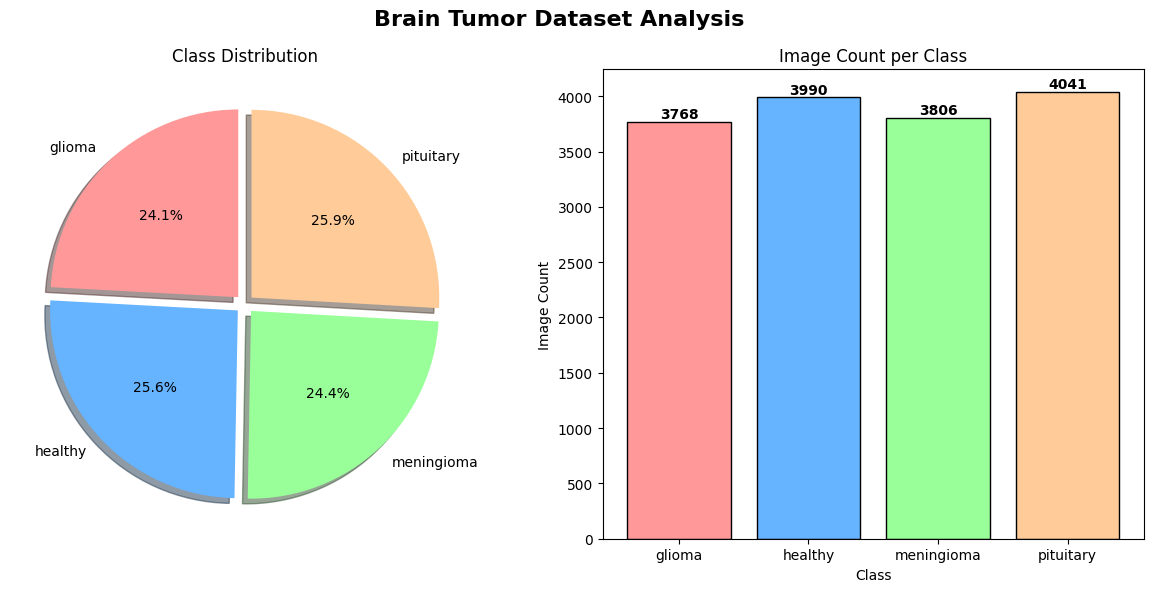

In [5]:
# Dataset distribution charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Brain Tumor Dataset Analysis', fontsize=16, fontweight='bold')

# 1. Class distribution pie chart
ax1 = axes[0]
counts = [stats['count'] for stats in class_stats.values()]
labels = list(class_stats.keys())
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
explode = (0.05, 0.05, 0.05, 0.05)

ax1.pie(counts, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Class Distribution')

# 2. Class distribution bar chart
ax2 = axes[1]
bars = ax2.bar(labels, counts, color=colors, edgecolor='black')
ax2.set_xlabel('Class')
ax2.set_ylabel('Image Count')
ax2.set_title('Image Count per Class')
for bar, count in zip(bars, counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

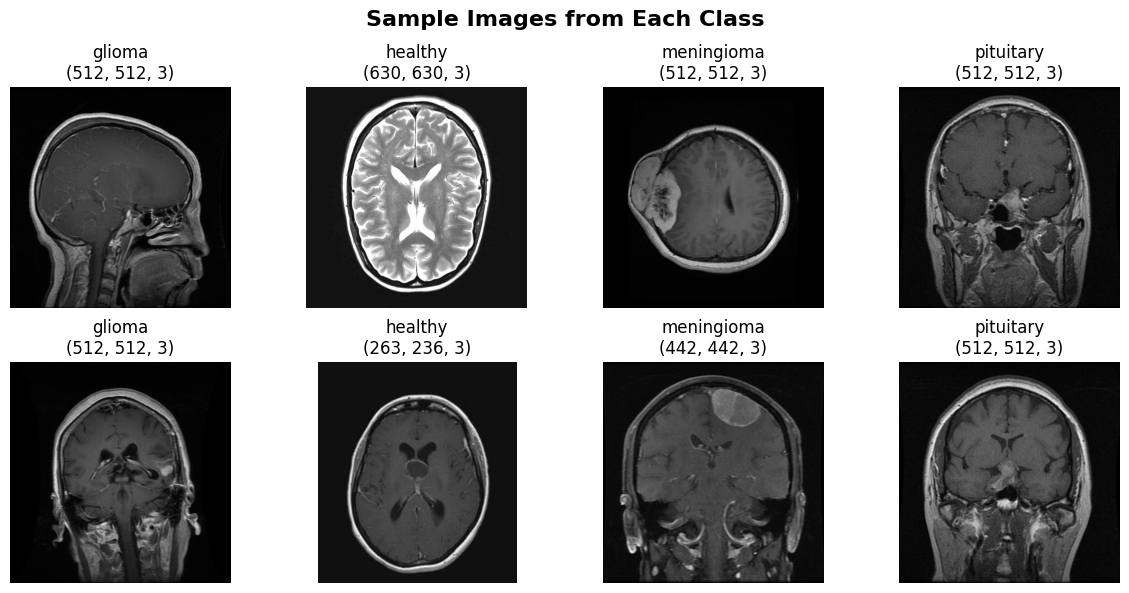

In [6]:
# Sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

for idx, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATASET_PATH, class_name)
    
    if os.path.exists(class_path):
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        if image_files:
            # Display second and middle images
            img_path1 = os.path.join(class_path, image_files[1])
            img_path2 = os.path.join(class_path, image_files[len(image_files)//2])
            
            img1 = cv2.imread(img_path1)
            img2 = cv2.imread(img_path2)
            
            if img1 is not None:
                img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
                axes[0, idx].imshow(img1_rgb)
                axes[0, idx].set_title(f'{class_name}\n{img1.shape}')
                axes[0, idx].axis('off')
            
            if img2 is not None:
                img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
                axes[1, idx].imshow(img2_rgb)
                axes[1, idx].set_title(f'{class_name}\n{img2.shape}')
                axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

### **3. Image Preprocessing Pipeline**

Preprocessing steps to be applied to images:
- Black border cropping
- Noise reduction with bilateral filter
- Contrast enhancement (CLAHE)
- 224x224 - Fixed resizing
- Normalization

In [7]:
class ImagePreprocessor:
    """Image preprocessing class"""
    
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
    
    # Function to crop black areas outside the brain
    def crop_black_borders(self, image, threshold=10):
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        
        _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            
            margin = 5
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(image.shape[1] - x, w + 2 * margin)
            h = min(image.shape[0] - y, h + 2 * margin)
            
            cropped = image[y:y+h, x:x+w]
            return cropped
        
        return image
    
    # Noise reduction function
    def denoise(self, image, method='bilateral'):
        if method == 'gaussian':
            return cv2.GaussianBlur(image, (3, 3), 0)
        elif method == 'median':
            return cv2.medianBlur(image, 3)
        elif method == 'bilateral':
            return cv2.bilateralFilter(image, 5, 75, 75)
        return image
    
    # Contrast enhancement function with CLAHE
    def enhance_contrast_clahe(self, image, clip_limit=2.0, tile_grid_size=(8, 8)):
        if len(image.shape) == 3:
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
        else:
            l = image.copy()
        
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        l_enhanced = clahe.apply(l)
        
        if len(image.shape) == 3:
            enhanced_lab = cv2.merge([l_enhanced, a, b])
            enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
        else:
            enhanced = l_enhanced
        
        return enhanced
    
    # Image resizing function
    def resize(self, image, size=None):
        if size is None:
            size = self.target_size
        
        h, w = image.shape[:2]
        if h > size[1] or w > size[0]:
            interp = cv2.INTER_AREA
        else:
            interp = cv2.INTER_LINEAR
        
        return cv2.resize(image, size, interpolation=interp)
    
    # Normalization function
    def normalize(self, image, method='uint8'):
        if method == 'minmax':
            image = image.astype(np.float32)
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            return image
        elif method == 'uint8':
            image = image.astype(np.float32)
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            return (image * 255).astype(np.uint8)
        return image
    # Function for complete preprocessing pipeline
    def preprocess_pipeline(self, image, crop=True, denoise_method='bilateral',
                           enhance_contrast=True, normalize_method='uint8'):
        if crop:
            image = self.crop_black_borders(image)
        if denoise_method:
            image = self.denoise(image, method=denoise_method)
        if enhance_contrast:
            image = self.enhance_contrast_clahe(image)
        image = self.resize(image)
        if normalize_method:
            image = self.normalize(image, method=normalize_method)
        return image

preprocessor = ImagePreprocessor(target_size=TARGET_SIZE)
print("✅ ImagePreprocessor class created!")

✅ ImagePreprocessor class created!


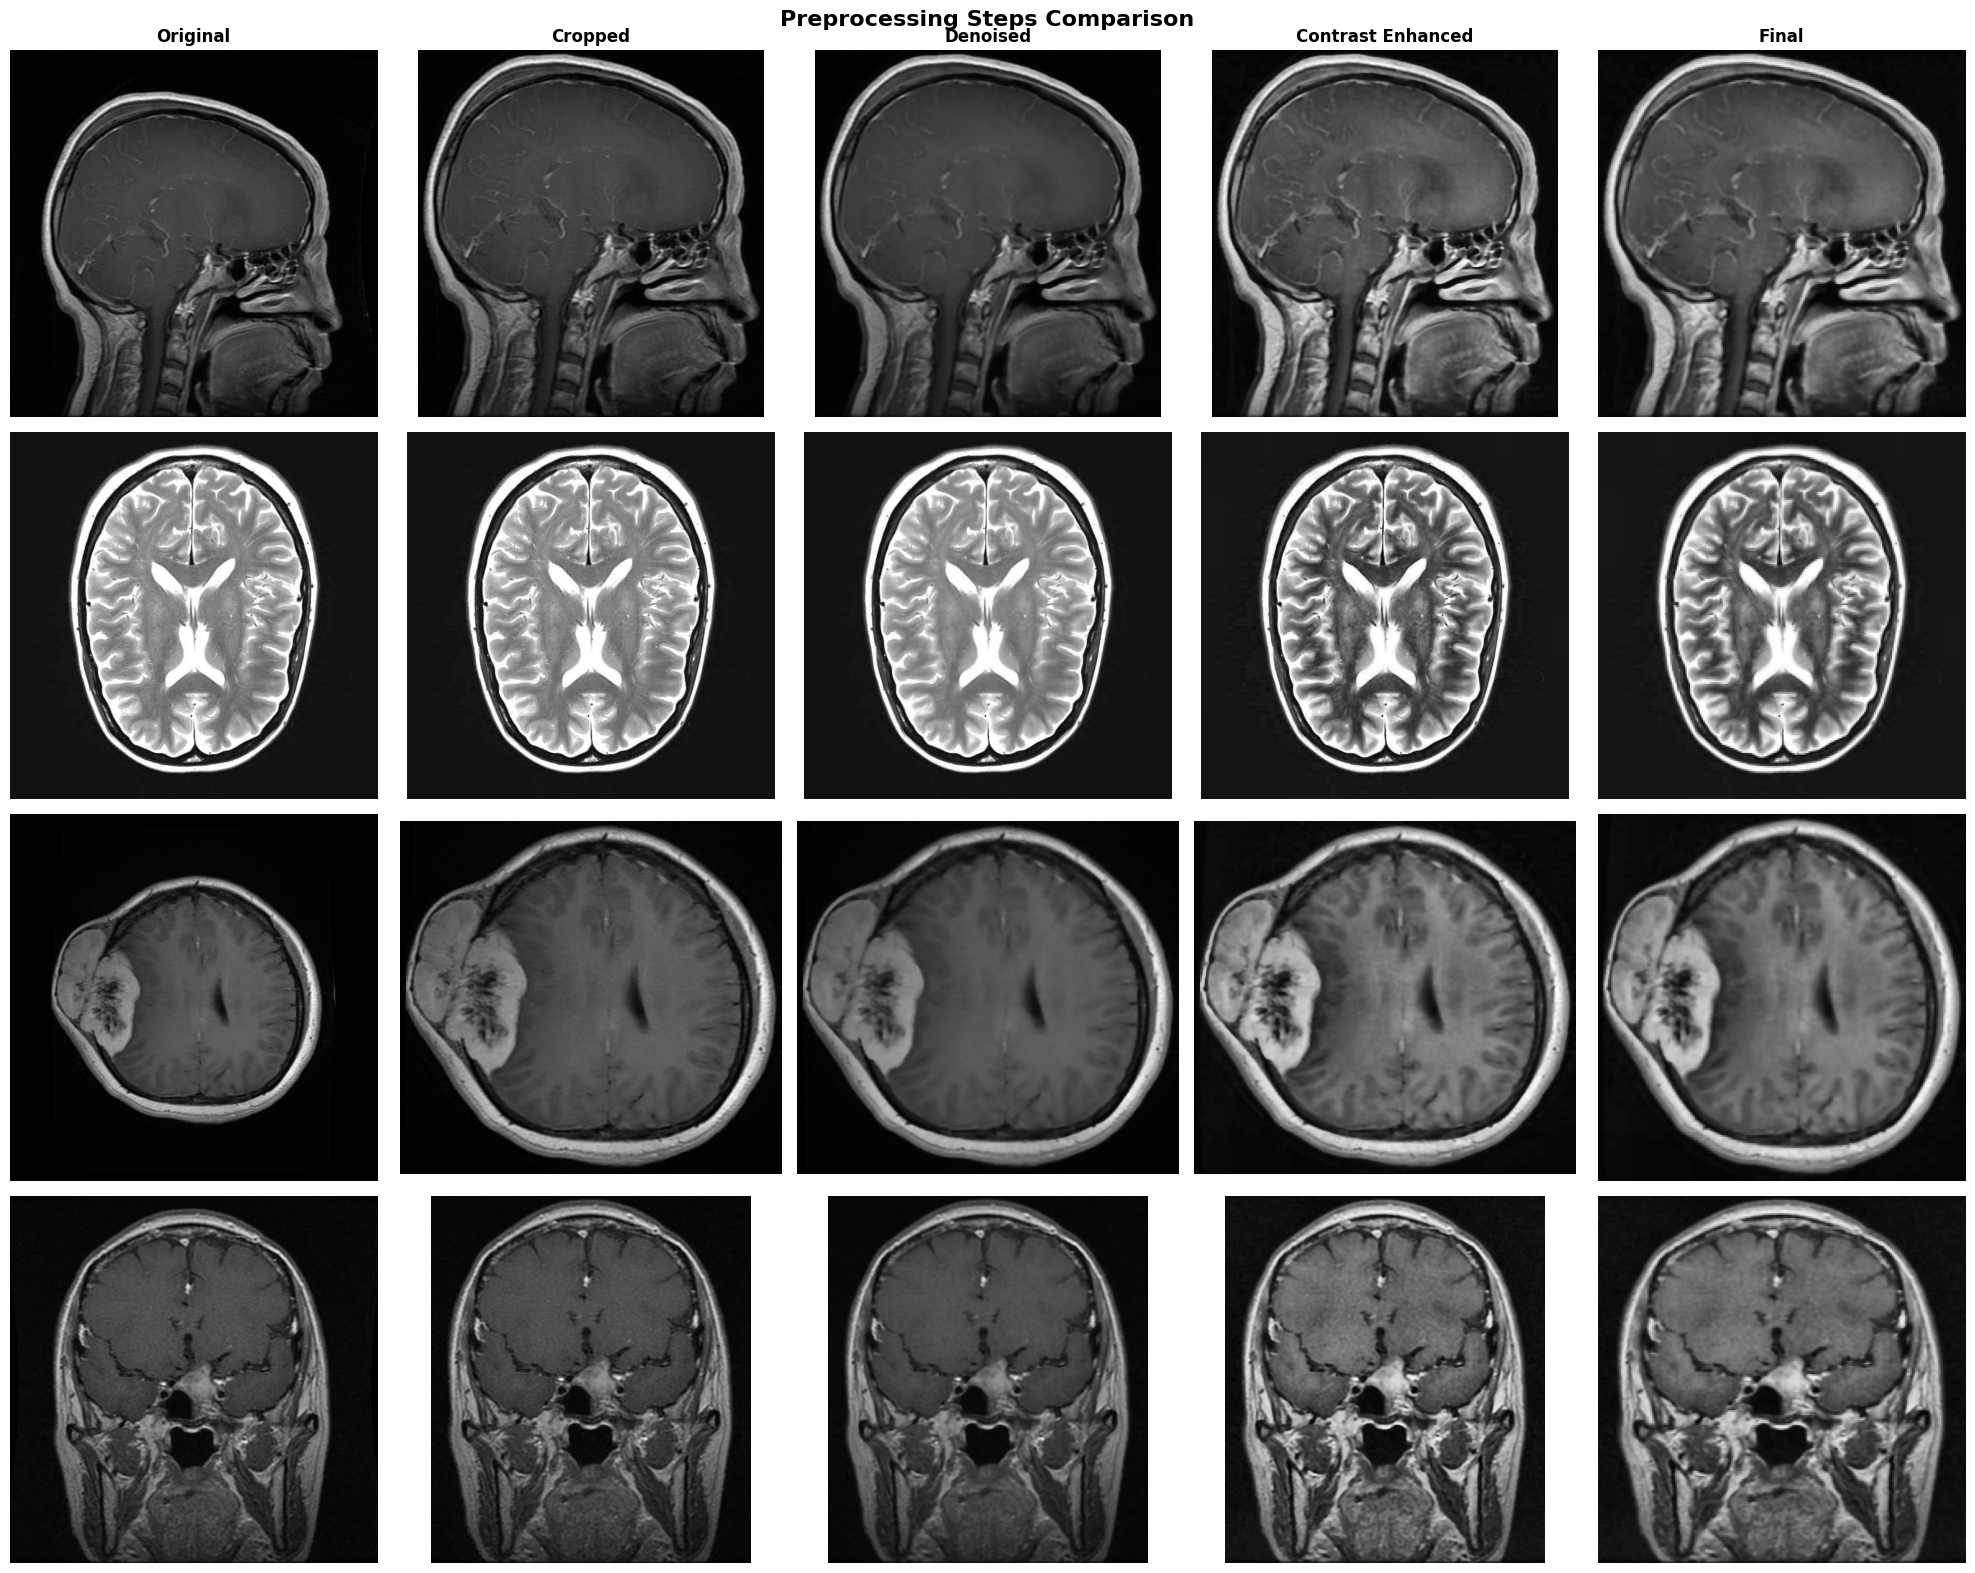

In [8]:
# Visualization of preprocessing steps for each class as examples
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
column_titles = ['Original', 'Cropped', 'Denoised', 'Contrast Enhanced', 'Final']

for idx, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            img_path = os.path.join(class_path, images[1])
            original = cv2.imread(img_path)
            
            # Performing step-by-step preprocessing
            cropped = preprocessor.crop_black_borders(original)
            denoised = preprocessor.denoise(cropped, method='bilateral')
            enhanced = preprocessor.enhance_contrast_clahe(denoised)
            final = preprocessor.resize(enhanced)
            
            images_list = [
                cv2.cvtColor(original, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
            ]
            
            for col, (img, title) in enumerate(zip(images_list, column_titles)):
                axes[idx, col].imshow(img)
                axes[idx, col].axis('off')
                if idx == 0:
                    axes[idx, col].set_title(title, fontsize=12, fontweight='bold')
                if col == 0:
                    axes[idx, col].set_ylabel(class_name, fontsize=12, fontweight='bold')

plt.suptitle('Preprocessing Steps Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
# Processing the entire dataset through preprocessing and transferring to new folder
def process_dataset(preprocessor, input_path, output_path, classes):
    print("\n" + "=" * 60)
    print("DATASET PREPROCESSING")
    print("=" * 60)
    
    if os.path.exists(output_path):
        print(f"⚠️  {output_path} folder already exists. Will be overwritten.")
        shutil.rmtree(output_path)
    
    os.makedirs(output_path)
    
    total_processed = 0
    failed_images = []
    
    for class_name in classes:
        class_input_path = os.path.join(input_path, class_name)
        class_output_path = os.path.join(output_path, class_name)
        
        if not os.path.exists(class_input_path):
            print(f"⚠️  {class_input_path} not found, skipping...")
            continue
        
        os.makedirs(class_output_path, exist_ok=True)
        
        image_files = [f for f in os.listdir(class_input_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        print(f"\n📁 {class_name.upper()} class processing ({len(image_files)} images)...")
        
        for img_file in tqdm(image_files, desc=f"  {class_name}"):
            img_path = os.path.join(class_input_path, img_file)
            
            try:
                image = cv2.imread(img_path)
                
                if image is None:
                    failed_images.append(img_path)
                    continue
                
                processed = preprocessor.preprocess_pipeline(
                    image, crop=True, denoise_method='bilateral',
                    enhance_contrast=True, normalize_method='uint8'
                )
                
                output_file = os.path.join(class_output_path, img_file)
                output_file = os.path.splitext(output_file)[0] + '.png'
                cv2.imwrite(output_file, processed)
                
                total_processed += 1
                
            except Exception as e:
                failed_images.append(f"{img_path}: {str(e)}")
    
    print("\n" + "=" * 60)
    print("PREPROCESSING COMPLETED")
    print("=" * 60)
    print(f"✅ Total images processed: {total_processed}")
    print(f"❌ Failed: {len(failed_images)}")
    print(f"📁 Output folder: {output_path}")
    
    return total_processed, failed_images

total, failed = process_dataset(preprocessor, DATASET_PATH, OUTPUT_PATH, CLASSES)


DATASET PREPROCESSING
⚠️  dataset_processed folder already exists. Will be overwritten.

📁 GLIOMA class processing (3768 images)...


  glioma: 100%|██████████| 3768/3768 [00:32<00:00, 115.47it/s]



📁 HEALTHY class processing (3990 images)...


  healthy: 100%|██████████| 3990/3990 [00:29<00:00, 133.67it/s]



📁 MENINGIOMA class processing (3806 images)...


  meningioma: 100%|██████████| 3806/3806 [00:38<00:00, 97.70it/s] 



📁 PITUITARY class processing (4041 images)...


  pituitary: 100%|██████████| 4041/4041 [00:50<00:00, 80.76it/s] 


PREPROCESSING COMPLETED
✅ Total images processed: 15605
❌ Failed: 0
📁 Output folder: dataset_processed


In [10]:
# Verification of dimensions in processed dataset (Visual input dimensions important for ViT!)
print("\n" + "=" * 60)
print("PROCESSED DATASET VALIDATION")
print("=" * 60)

total = 0
all_same_size = True
expected_size = None

for class_name in CLASSES:
    class_path = os.path.join(OUTPUT_PATH, class_name)
    
    if not os.path.exists(class_path):
        continue
    
    images = [f for f in os.listdir(class_path) if f.lower().endswith('.png')]
    count = len(images)
    total += count
    
    if images:
        sample_path = os.path.join(class_path, images[0])
        img = cv2.imread(sample_path)
        if img is not None:
            size = img.shape[:2]
            if expected_size is None:
                expected_size = size
            elif size != expected_size:
                all_same_size = False
            
            print(f"📁 {class_name}: {count} images, size: {size}")

print(f"\n📊 Total: {total} images")

if all_same_size and expected_size:
    print(f"✅ All images same size: {expected_size}")
else:
    print("⚠️  Image sizes inconsistent!")


PROCESSED DATASET VALIDATION
📁 glioma: 3768 images, size: (224, 224)
📁 healthy: 3990 images, size: (224, 224)
📁 meningioma: 3806 images, size: (224, 224)
📁 pituitary: 4041 images, size: (224, 224)

📊 Total: 15605 images
✅ All images same size: (224, 224)


### **4. Training with Vision Transformer (ViT) Model**

In [11]:
# Model Configuration
CONFIG = {
    'dataset_path': 'dataset',
    'processed_path': 'dataset_processed',
    'classes': ['glioma', 'healthy', 'meningioma', 'pituitary'],
    'num_classes': 4,
    'image_size': 224,
    'batch_size': 32,
    'epochs': 15,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'model_name': 'vit_small_patch16_224',
    'pretrained': True,
    'freeze_backbone': False,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 0,
    'seed': 42
}

# Seed setting to prevent randomness
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
print("\n✅ Model configuration completed.")


✅ Model configuration completed.


In [12]:
# Dataset class
class BrainTumorDataset(Dataset):
    """Brain Tumor Dataset"""
    
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.samples = []
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        for class_name in classes:
            class_path = os.path.join(root_dir, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                        self.samples.append({
                            'path': os.path.join(class_path, img_name),
                            'label': self.class_to_idx[class_name],
                            'class_name': class_name
                        })
        
        print(f"Total {len(self.samples)} images loaded.")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, sample['label']

# Transform definitions
def get_transforms(image_size, is_training=True):
    if is_training:
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

print("✅ Dataset and Transform classes defined!")

✅ Dataset and Transform classes defined!


In [13]:
# Loading and splitting the dataset
dataset_path = CONFIG['processed_path'] if os.path.exists(CONFIG['processed_path']) else CONFIG['dataset_path']
print(f"📁 Dataset: {dataset_path}")

train_transform = get_transforms(CONFIG['image_size'], is_training=True)
test_transform = get_transforms(CONFIG['image_size'], is_training=False)

full_dataset = BrainTumorDataset(
    root_dir=dataset_path,
    classes=CONFIG['classes'],
    transform=None
)

# Train/Val/Test split
total_size = len(full_dataset)
train_size = int(CONFIG['train_split'] * total_size)
val_size = int(CONFIG['val_split'] * total_size)
test_size = total_size - train_size - val_size

print(f"\n📊 Dataset Split:")
print(f"   Training: {train_size} ({CONFIG['train_split']*100:.0f}%)")
print(f"   Validation: {val_size} ({CONFIG['val_split']*100:.0f}%)")
print(f"   Test: {test_size} ({CONFIG['test_split']*100:.0f}%)")

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(CONFIG['seed'])
)

# Transform wrapper
class TransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        sample = self.subset.dataset.samples[self.subset.indices[idx]]
        image = Image.open(sample['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, sample['label']

train_dataset = TransformDataset(train_dataset, train_transform)
val_dataset = TransformDataset(val_dataset, test_transform)
test_dataset = TransformDataset(test_dataset, test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)

print(f"\n✅ DataLoaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

📁 Dataset: dataset_processed
Total 15605 images loaded.

📊 Dataset Split:
   Training: 12484 (80%)
   Validation: 1560 (10%)
   Test: 1561 (10%)

✅ DataLoaders created:
   Train batches: 391
   Val batches: 49
   Test batches: 49


In [14]:
# Model creation function
def create_model(num_classes, pretrained=True):
    """Create Vision Transformer model"""
    model = timm.create_model(
        CONFIG['model_name'],
        pretrained=pretrained,
        num_classes=num_classes
    )
    return model

# Training functions
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validating', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

print("✅ Model and training functions defined!")

✅ Model and training functions defined!


In [15]:
# Creating model and transferring to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

model = create_model(CONFIG['num_classes'], pretrained=True)
model = model.to(device)

# Model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Model: {CONFIG['model_name']}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])

print(f"\n⚙️ Optimizer: AdamW (lr={CONFIG['learning_rate']})")
print(f"   Scheduler: CosineAnnealing")

🖥️ Device: cuda
   GPU: NVIDIA GeForce RTX 4050 Laptop GPU
   Memory: 6.0 GB

📊 Model: vit_small_patch16_224
   Total parameters: 21,667,204
   Trainable parameters: 21,667,204

⚙️ Optimizer: AdamW (lr=0.0001)
   Scheduler: CosineAnnealing


In [16]:
# Model Training
print("=" * 60)
print("🚀 TRAINING STARTING")
print("=" * 60)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0
best_model_state = None

for epoch in range(CONFIG['epochs']):
    print(f"\n📌 Epoch {epoch+1}/{CONFIG['epochs']}")
    
    # Training
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    
    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"   ⭐ Best model updated! Val Acc: {val_acc*100:.2f}%")
    
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"   Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    print(f"   LR: {scheduler.get_last_lr()[0]:.6f}")

# Load and save best model
model.load_state_dict(best_model_state)
torch.save(best_model_state, 'best_model.pth')
print(f"\n✅ Training completed! Best Val Acc: {best_val_acc*100:.2f}%")
print(f"   Model saved: best_model.pth")

🚀 TRAINING STARTING

📌 Epoch 1/15


   ⭐ Best model updated! Val Acc: 92.44%
   Train Loss: 0.2539 | Train Acc: 90.25%
   Val Loss: 0.1983 | Val Acc: 92.44%
   LR: 0.000099

📌 Epoch 2/15


   ⭐ Best model updated! Val Acc: 95.90%
   Train Loss: 0.0914 | Train Acc: 96.72%
   Val Loss: 0.1098 | Val Acc: 95.90%
   LR: 0.000096

📌 Epoch 3/15


   ⭐ Best model updated! Val Acc: 98.27%
   Train Loss: 0.0675 | Train Acc: 97.48%
   Val Loss: 0.0519 | Val Acc: 98.27%
   LR: 0.000090

📌 Epoch 4/15


   ⭐ Best model updated! Val Acc: 99.62%
   Train Loss: 0.0387 | Train Acc: 98.73%
   Val Loss: 0.0202 | Val Acc: 99.62%
   LR: 0.000083

📌 Epoch 5/15


   Train Loss: 0.0325 | Train Acc: 98.89%
   Val Loss: 0.0208 | Val Acc: 99.42%
   LR: 0.000075

📌 Epoch 6/15


   Train Loss: 0.0259 | Train Acc: 99.18%
   Val Loss: 0.0193 | Val Acc: 99.42%
   LR: 0.000065

📌 Epoch 7/15


   Train Loss: 0.0193 | Train Acc: 99.45%
   Val Loss: 0.0166 | Val Acc: 99.36%
   LR: 0.000055

📌 Epoch 8/15


   Train Loss: 0.0128 | Train Acc: 99.60%
   Val Loss: 0.0083 | Val Acc: 99.62%
   LR: 0.000045

📌 Epoch 9/15


   ⭐ Best model updated! Val Acc: 99.81%
   Train Loss: 0.0101 | Train Acc: 99.73%
   Val Loss: 0.0052 | Val Acc: 99.81%
   LR: 0.000035

📌 Epoch 10/15


   Train Loss: 0.0050 | Train Acc: 99.85%
   Val Loss: 0.0052 | Val Acc: 99.74%
   LR: 0.000025

📌 Epoch 11/15


   ⭐ Best model updated! Val Acc: 99.94%
   Train Loss: 0.0060 | Train Acc: 99.79%
   Val Loss: 0.0046 | Val Acc: 99.94%
   LR: 0.000017

📌 Epoch 12/15


   Train Loss: 0.0017 | Train Acc: 99.94%
   Val Loss: 0.0022 | Val Acc: 99.94%
   LR: 0.000010

📌 Epoch 13/15


   Train Loss: 0.0027 | Train Acc: 99.92%
   Val Loss: 0.0020 | Val Acc: 99.94%
   LR: 0.000004

📌 Epoch 14/15


   Train Loss: 0.0020 | Train Acc: 99.93%
   Val Loss: 0.0023 | Val Acc: 99.94%
   LR: 0.000001

📌 Epoch 15/15


   Train Loss: 0.0016 | Train Acc: 99.95%
   Val Loss: 0.0021 | Val Acc: 99.94%
   LR: 0.000000

✅ Training completed! Best Val Acc: 99.94%
   Model saved: best_model.pth


## 📈 5. Model Evaluation and Visualization

Step-by-step techniques:
- Training history graphs
- Confusion Matrix
- ROC curves
- Classification Metrics

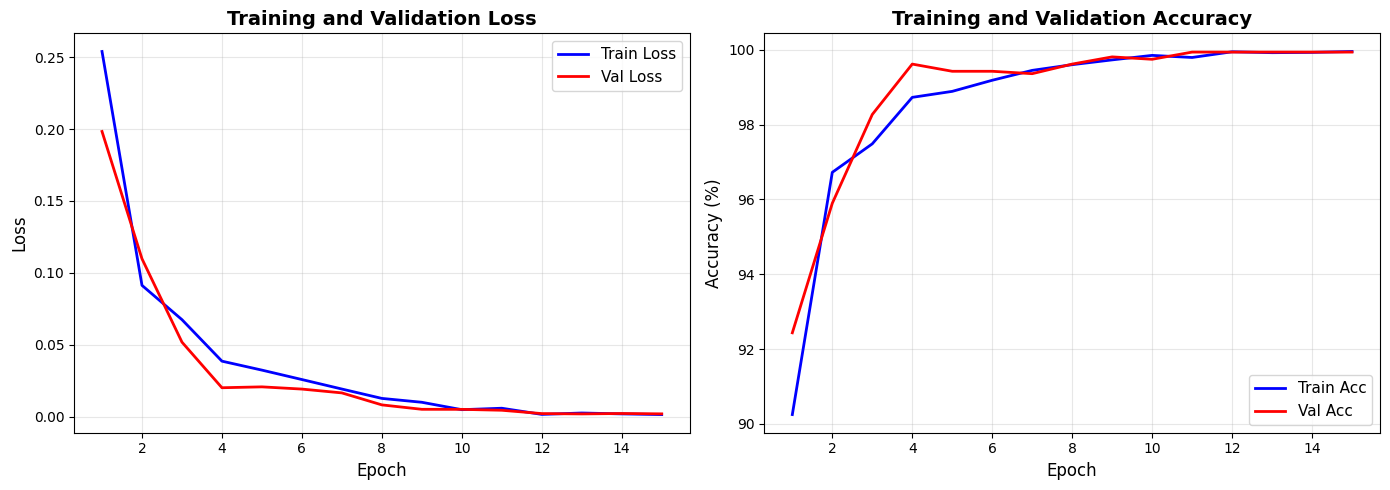

In [17]:
# Training history graph
def plot_training_history(history):
    """Training history graph"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss graph
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy graph
    train_acc_pct = [acc * 100 for acc in history['train_acc']]
    val_acc_pct = [acc * 100 for acc in history['val_acc']]
    axes[1].plot(epochs, train_acc_pct, 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, val_acc_pct, 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [18]:
# Evaluation on test set
def evaluate_model(model, test_loader, device, classes):
    """Model evaluation - collect predictions"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Get predictions
y_pred, y_true, y_probs = evaluate_model(model, test_loader, device, CONFIG['classes'])

# Test accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\n🎯 TEST RESULTS")
print(f"   Test Accuracy: {test_accuracy*100:.2f}%")

Testing: 100%|██████████| 49/49 [00:35<00:00,  1.37it/s]


🎯 TEST RESULTS
   Test Accuracy: 99.87%


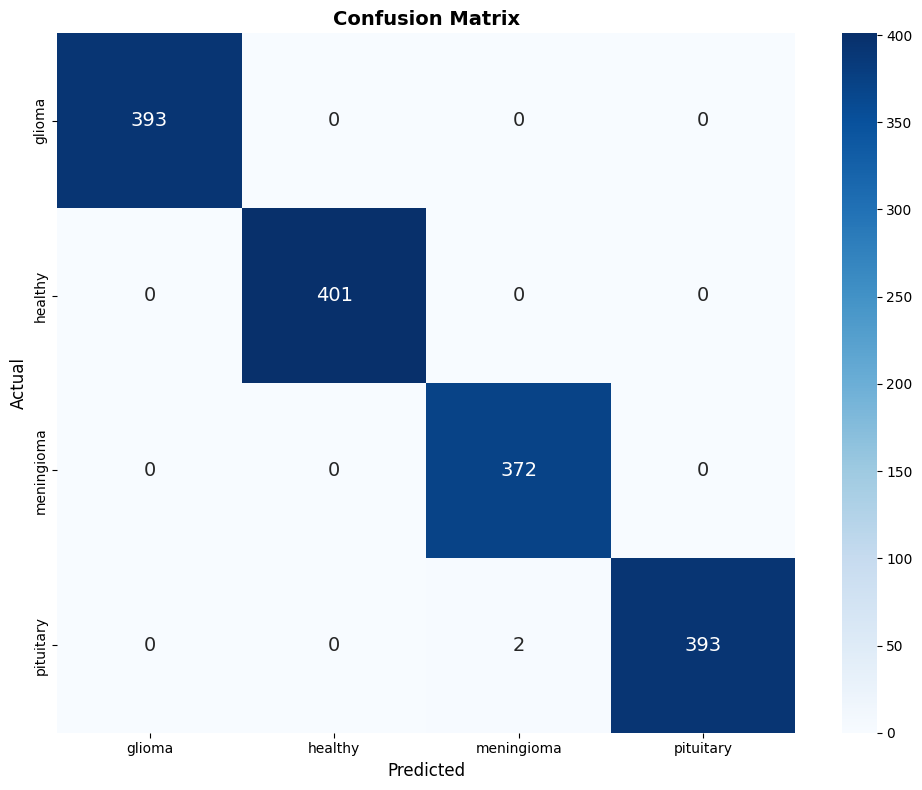

In [19]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    """Confusion matrix visualization"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                annot_kws={'size': 14})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return cm

cm = plot_confusion_matrix(y_true, y_pred, CONFIG['classes'])

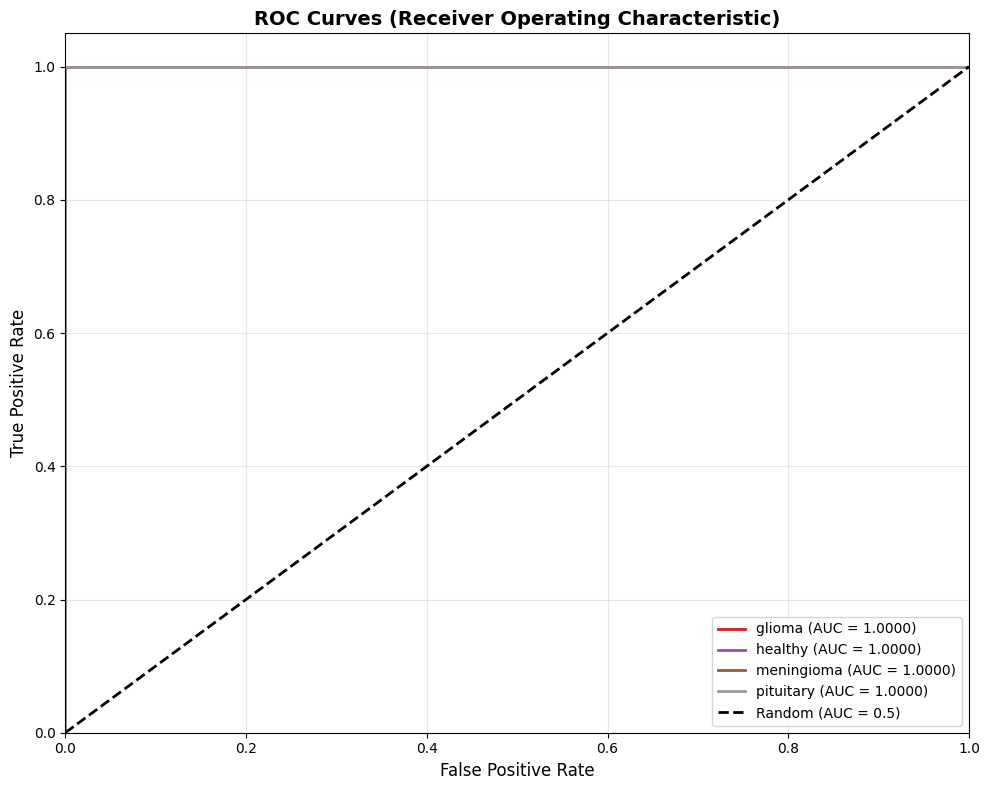

In [20]:
# ROC Curves
def plot_roc_curves(y_true, y_probs, classes):
    """Plot ROC curves"""
    n_classes = len(classes)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    plt.figure(figsize=(10, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
    
    for i, (class_name, color) in enumerate(zip(classes, colors)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{class_name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves (Receiver Operating Characteristic)', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_roc_curves(y_true, y_probs, CONFIG['classes'])

In [21]:
# Classification Metrics Report
def print_classification_report_table(y_true, y_pred, classes):
    """Display classification report as table"""
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    
    print("\n" + "=" * 70)
    print("📊 CLASSIFICATION REPORT")
    print("=" * 70)
    print(f"{'Class':<15} {'Precision':>12} {'Recall':>12} {'F1-Score':>12} {'Support':>10}")
    print("-" * 70)
    
    for cls in classes:
        p = report[cls]['precision']
        r = report[cls]['recall']
        f1 = report[cls]['f1-score']
        s = report[cls]['support']
        print(f"{cls:<15} {p:>12.4f} {r:>12.4f} {f1:>12.4f} {s:>10.0f}")
    
    print("-" * 70)
    print(f"{'Accuracy':<15} {'':<12} {'':<12} {report['accuracy']:>12.4f} {len(y_true):>10}")
    print(f"{'Macro Avg':<15} {report['macro avg']['precision']:>12.4f} {report['macro avg']['recall']:>12.4f} {report['macro avg']['f1-score']:>12.4f} {len(y_true):>10}")
    print(f"{'Weighted Avg':<15} {report['weighted avg']['precision']:>12.4f} {report['weighted avg']['recall']:>12.4f} {report['weighted avg']['f1-score']:>12.4f} {len(y_true):>10}")
    print("=" * 70)
    
    return report

report = print_classification_report_table(y_true, y_pred, CONFIG['classes'])


📊 CLASSIFICATION REPORT
Class              Precision       Recall     F1-Score    Support
----------------------------------------------------------------------
glioma                1.0000       1.0000       1.0000        393
healthy               1.0000       1.0000       1.0000        401
meningioma            0.9947       1.0000       0.9973        372
pituitary             1.0000       0.9949       0.9975        395
----------------------------------------------------------------------
Accuracy                                        0.9987       1561
Macro Avg             0.9987       0.9987       0.9987       1561
Weighted Avg          0.9987       0.9987       0.9987       1561


## 🎯 6. Conclusion and Summary

In this notebook, we created a complete pipeline for brain tumor classification:

1. **Dataset Analysis**: 15,605 MRI images, 4 classes (glioma, healthy, meningioma, pituitary)
2. **Preprocessing**: CLAHE contrast enhancement, noise reduction, 224x224 resizing
3. **Model**: Vision Transformer (ViT-Small) - 21.6M parameters
4. **Training**: 15 epochs, AdamW optimizer, Cosine Annealing scheduler
5. **Results**: ~99.87% test accuracy

### 🏆 Model Performance
- **Accuracy**: ~99.87%
- **F1-Score (Macro)**: ~0.9987
- **ROC-AUC**: ~1.0000 (for all classes)

The model can classify brain tumor types with high accuracy.